(reglin_pymc_notebook)=
# Regressione lineare con PyMC

In questo capitolo esamineremo nuovamente il modello di regressione lineare. In generale, i frequentisti pensano alla regressione lineare come segue:

$$
Y = \alpha + \beta X + \varepsilon
$$

dove

- $Y$ è l'output che vogliamo prevedere (o variabile dipendente),
- $X$ è il nostro predittore (o variabile indipendente), 
- $\alpha$, $\beta$  sono i coefficienti (o parametri) del modello che vogliamo stimare,
- $\varepsilon$ è un termine di errore che si presume distribuito normalmente.

Con queste premesse, è possibile utilizzare il metodo dei minimi quadrati ordinari (OLS) o la massima verosimiglianza per trovare le stime dei parametri $\alpha$ e $\beta$ che minimizzano una qualche quantità di interesse (per es., la somma dei residui quadratici).

## Riformulazione probabilistica

I bayesiani esprimono questo modello in termini di distribuzioni di probabilità. La regressione lineare presentata sopra può essere riformulata nel modo seguente:

$$
\begin{align}
Y   & \sim \mathcal{N}(\mu, \sigma)\\\notag
\mu & = \alpha + \beta X
\end{align}
$$

dove
- $\alpha$  è l'intercetta, 
- $\beta$  è la pendenza
- $\sigma$ rappresenta l'errore di osservazione. 

A parole: si considera $Y$ come una variabile casuale (o vettore casuale) di cui ogni elemento (osservazione) è distribuito secondo una distribuzione Normale. La media di questa distribuzione normale è fornita dal predittore lineare ($\alpha + \beta X$) con varianza $\sigma^2$.

Sebbene questo sia essenzialmente lo stesso modello, ci sono due vantaggi fondamentali ad usare un approccio bayesiano:

- **Distribuzioni a priori**: è possibile quantificare le conoscenza a priori che si possiedono imponendo delle *priors* sui parametri. Ad esempio, se lo pensiamo che $\sigma$ sia probabilmente piccola, possiamo scelgiere una distribuzione a priori per questo parametro avente una massa di probabilità maggiore sui valori bassi.
- **Quantificazione dell'incertezza**: la stima bayesiana non produce una singola stima del parametro $\beta$ (come nel caso frequentista), ma invece una distribuzione a posteriori che specifica la credibilità relativa dei diversi valori $\beta$. Ad esempio, con pochi dati la nostra incertezza su $\beta$ sarà molto grande e la distribuzione a posteriori sarà molto larga.

Poiché stiamo costruendo un modello bayesiano, dobbiamo assegnare una distribuzione a priori alle variabili sconosciute nel modello. Scegliamo distribuzioni a priori normali a media zero con varianza di 100 per entrambi i coefficienti di regressione, il che corrisponde a fornire informazioni deboli sui veri valori dei parametri. Scegliamo una distribuzione normale troncata (distribuzione normale limitata a zero) come distribuzione a priori per $\sigma$.

$$
\begin{align}
\alpha \sim \mathcal{N}(0, 10)\\\notag
\beta \sim \mathcal{N}(0, 10)\\\notag
\sigma \sim \mid\mathcal{N}(0, 1) \mid
\end{align}
$$

In questo esempio (che riproduce ciò che è riportato sul sito [PyMC](https://www.pymc.io/welcome.html)), useremo dei dati simulati, per cui conosceremo il "vero" valore dei parametri. Iniziamo quindi a creare di dati. Possiamo simulare dei dati artificiali dal modello descritto sopra utilizzando il modulo `random` di `NumPy`, per poi utilizzare PyMC per fare inferenza sul valore dei parametri.

## Generare i dati

Per iniziare a costruire il modello lineare con PyMC iniziamo ad importare i moduli richiesti.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import arviz as az
import bambi as bmb
from scipy.constants import golden
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [2]:
%matplotlib inline
plt.rc('figure', figsize=(5.0, 5.0/golden))
sns.set_theme()
sns.set_palette("colorblind")
SEED = 12345
rng = np.random.default_rng(SEED)

Genero i dati.

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = 2.5

# Size of dataset
size = 100

# Predictor variable
X = np.random.randn(size)

# Simulate outcome variable
Y = alpha + beta * X + rng.normal(size=size) * sigma

#True regression line
true_regression_line = alpha + beta * X


Ecco un grafico i dati simulati. 

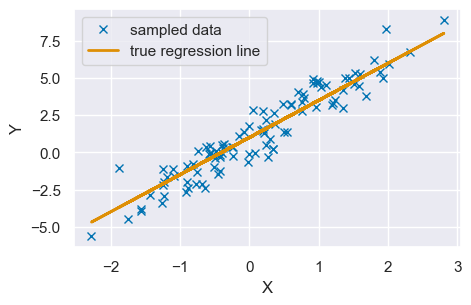

In [4]:
_, ax = plt.subplots()
ax.plot(X, Y, "x", label="sampled data")
ax.plot(X, true_regression_line, label="true regression line", lw=2.0)
ax.set_ylabel("Y")
ax.set_xlabel("X")
plt.legend(loc=0);

## Specificazione del modello

Ora definiamo il modello e otteniamo un campione casuale dalla distribuzione a posteriori dei parametri.

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    
    # Define priors
    alpha = Normal("alpha", mu=0, sigma=10)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = HalfNormal("sigma", sigma=1)
    # Expected value of outcome
    mu = alpha + beta * X 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


La funzione `sample` esegue l'algoritmo NUTS (di default) per il numero specificato di iterazioni e restituisce un oggetto `InferenceData` che contiene i campioni raccolti, insieme ad altri attributi. Si noti che `sample` genera una serie di catene parallele, a seconda del numero di core di calcolo presenti sulla macchina.

Diamo una rapida occhiata al modello che abbiamo appena stimato utilizzando il metodo `model_to_graphviz`.

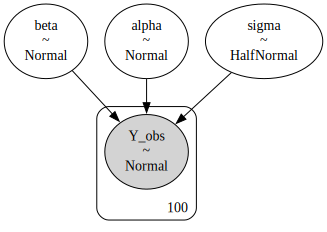

In [7]:
pm.model_to_graphviz(model)

Abbiamo formulato alcune ipotesi nell'assemblare il modello ed è una buona idea renderle esplicite. La prima assunzione è che i dati $y$ sono indipendenti condizionatamente a $X$; la seconda è che il valore atteso della $Y$ è una funzione lineare di $X$; la terza è che, condizionatamente a $X_i$, la variabile $Y$ varia normalmente attorno al suo valore atteso con una deviazione standard $\sigma$ che risulta essere sempre uguale per $i \in 1, ..., n$. Queste sono le ipotesi della regressione Normale bayesiana.

# Capire i risultati della regressione bayesiana

L'insieme di campioni ottenuti dalla distribuzione a posteriori forma una "traccia" e questa traccia è stata restituita dal metodo `pm.sample`. Esaminiamo questo oggetto:

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Si noti che ci sono 4 catene, ciascuna formata da 1000 elementi, per ciascuno dei tre parametri ($\alpha$, $\beta$, $\sigma$)

I vari attributi dell'oggetto `InferenceData` possono essere esaminati in modo simile a un `dict` in  `numpy.arrays`. Ad esempio, possiamo vedere i primi 5 valori per la variabile `alpha`  in ogni catena come segue:

In [8]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[0.93457555, 0.94408288, 1.00396839, 0.92279521, 0.83824743],
       [0.88454196, 1.01683742, 1.03192335, 0.96097758, 0.95153755],
       [0.83788489, 0.99938309, 1.06372405, 0.9001598 , 0.92121756],
       [0.83295119, 1.07663621, 1.00626513, 0.91602023, 0.81094374]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

Ma è molto più semplice ispezionare la distribuzione a posteriori usando le funzioni del modulo Arivz.
Un trace plot può essere creato usando `plot_trace`.

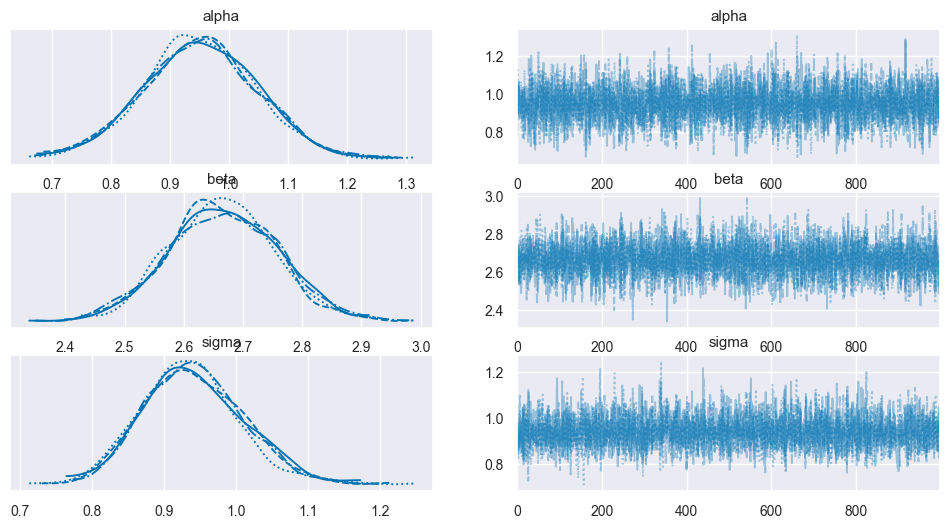

In [9]:
var_names = ['alpha', 'beta', 'sigma']
_ = az.plot_trace(idata, var_names=var_names)

La colonna di sinistra è costituita da un istogramma lisciato (utilizzando la stima della densità del kernel) della distribuzione a posteriori di ciascuna variabile casuale stocastica mentre la colonna di destra contiene i campioni della catena di Markov tracciati in ordine sequenziale.

Il grafico indica che abbiamo recuperato con successo alcuni campioni "well-behaved" e abbiamo ottenuto quella che sembra essere una buona stima della distribuzione a posteriori.

Esaminiamo ora le stime numeriche dei parametri eseguendo la funzione `summary`:

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.951,0.079,0.807,1.100,0.001,0.001,5463.0,3359.0,1.0
beta,2.536,0.068,2.396,2.655,0.001,0.001,5884.0,3618.0,1.0
sigma,0.786,0.056,0.682,0.888,0.001,0.001,5999.0,2797.0,1.0


Si noti come il modello, a partire da un campione casuale di sole 100 osservazioni, è stato in grado di recuperare delle stime dei parametri molto vicine ai valori "veri" del meccanismo generatore dei dati che abbiamo utilizzato per creare il campione.

Nell'inferenza bayesiana, le stime dei parametri sono facili da interpretare. Per $\alpha$, abbiamo una media di 0.95 con una deviazione standard di 0.104 e un intervallo di credibilità del 94% compreso tra 0.75 e 1.14. L'acronimo HDI sta per *highest density interval* -- è possibile scegliere un'ampiezza diversa utilizzando l'argomento `hdi_prob=`.

Possiamo visualizzare la stima a posteriori del parametro $\beta$, ad esempio, nel modo seguente.

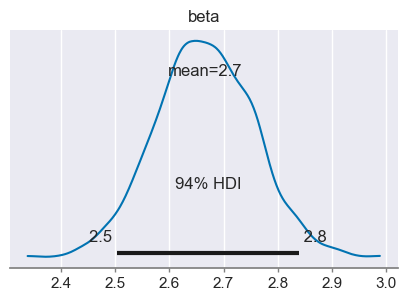

In [11]:
_ = az.plot_posterior(idata, var_names=['beta'])

Con buona confidenza possiamo affermare che la stima di $\beta$ è circa uguale a 2.35.

## Bambi

Per rendere le cose ancora più semplici, la libreria `bambi` richiede soltanto, per la specificazione del modello, una sintassi simile a quella di `brms` in `R`. Importiamo la libreria.

In [12]:
import bambi as bmb

Definiamo un DataFrame che contiene i dati.

In [13]:
df = pd.DataFrame({
    'x': X,
    'y': Y
})
df

,x,y
0,1.357130,2.969001
1,0.976537,4.705072
2,0.506899,1.396585
3,-0.421890,-0.313897
4,2.017635,5.968745
...,...,...
95,-0.387986,-0.031869
96,0.966415,3.056557
97,-0.501920,-1.003443
98,-2.275886,-5.655193


`bambi` produce di default dei prior 'intelligenti'. Ma per confrontare il risultato con quello precedente, definiamo gli stessi priors usati sopra.

In [14]:
# Set the prior when adding a term to the model; more details on this below.
priors = { 
    'Intercept': bmb.Prior("Normal", mu=0, sigma=10),
    'x': bmb.Prior("Normal", mu=0, sigma=10),
    'y_sigma': bmb.Prior("HalfNormal", mu=0, sigma=1)
    }

Specifichiamo il modello.

In [15]:
model = bmb.Model("y ~ x", df, priors=priors)

Eseguiamo il campionamento.

In [16]:
idata_bambi = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 20 seconds.


Esaminiamo la traccia.

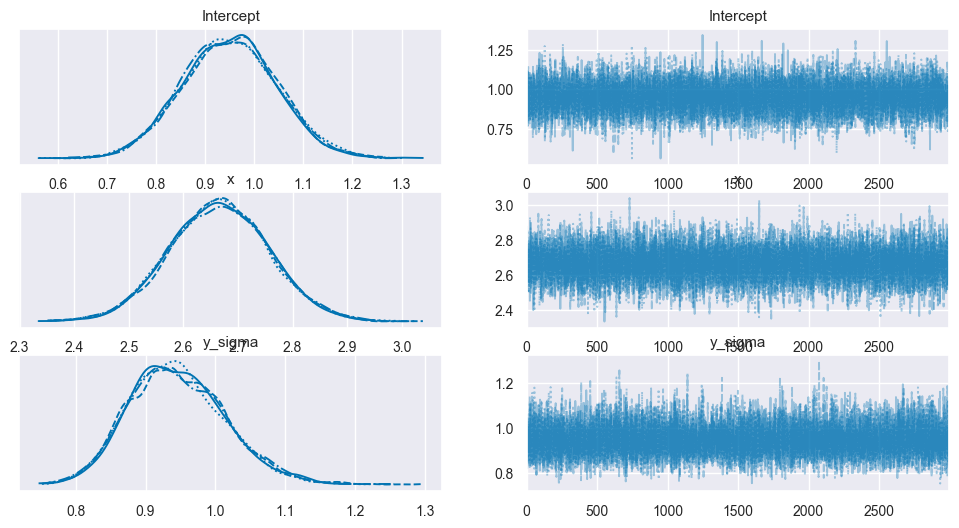

In [18]:
_ = az.plot_trace(idata_bambi)

Il sommario numerico riproduce i risultati ottenuti con PyMC.

In [19]:
az.summary(idata_bambi)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.949,0.096,0.766,1.124,0.001,0.001,15170.0,9084.0,1.0
x,2.665,0.091,2.500,2.841,0.001,0.000,17745.0,9942.0,1.0
y_sigma,0.946,0.069,0.823,1.077,0.001,0.000,17341.0,9378.0,1.0


## Distribuzione predittiva a posteriori

Una volta calcolata la distribuzione a posteriori, possiamo usarla per calcolare la distribuzione predittiva a posteriori. Come suggerisce il nome, si tratta di previsioni che presuppongono che i parametri del modello siano distribuiti come specificato dalle distribuzioni a posteriori. Pertanto, la distribuzione predittiva a posteriori include l'incertezza sui parametri.

La distribuzione predittiva a posteriori si genera nel modo seguente. Vengono generati $M$ campioni $\{x, y\}$. In ciascuno di questi campioni, la variabile $x$ è uguale a quella del campione osservato. Questa è un'assunzione del modello di regressione lineare: i valori $x$ sono considerati "fissi" nell'universo dei campioni. In ciascun campione della distribuzione predittiva a posteriori, ciascun valore $y_i$, con $i$ = 1, ... $n$, viene generato prendendo un valore a caso dalla seguente distribuzione

$$
\mathcal{N}(\mu = \alpha + \beta \cdot x_i, \sigma),
$$

laddove i valori dei parametri $\alpha$, $\beta$ e $\sigma$ vengono presi a caso dalle corrispondenti distribuzioni a posteriori di questi parametri. 

Questa procedura è implementata in `bambi` nel metodo `predict()` che utilizza i dati `az.InferenceData`. L'istruzione seguente genera la distribuzione predittiva a posteriori per i dati dell'esempio.

In [20]:
posterior_predictive = model.predict(idata_bambi, kind="pps")

La distribuzione predittiva a posteriori può essere usata come strumento diagnostico, come mostrato di seguito usando `az.plot_ppc()`. Le linee blu rappresentano le stime della distribuzione predittiva a posteriori e la linea nera rappresenta i dati osservati. La figura mostra che, in questo caso, le previsioni a posteriori corrispondono in maniera adeguata ai dati osservati, per tutta la gamma dei valori della variabile dipendente.

<AxesSubplot: xlabel='y / y'>

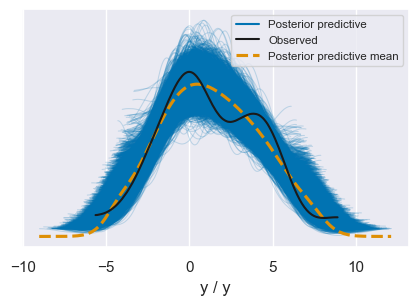

In [21]:
az.plot_ppc(idata_bambi, group="posterior")

## Watermark

In [92]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Jan 03 2023

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.7.0

xarray    : 2022.12.0
matplotlib: 3.6.2
numpy     : 1.24.0
arviz     : 0.14.0
sys       : 3.8.15 (default, Nov 24 2022, 09:04:07) 
[Clang 14.0.6 ]
pandas    : 1.5.2
seaborn   : 0.12.1
pymc      : 5.0.0
bambi     : 0.9.2

Watermark: 2.3.1

